In [1]:
import pandas as pd
online=pd.read_csv("OrderData.csv")

C:\Users\POPO\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
####把退貨資料排除在RFM資料之外
online=online[online["TotalSalesAmount"]>0]
online.head()

,TradesGroupCode,TradesDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,TsCount,Qty,TotalSalesAmount,TotalPrice,TotalDiscount,TotalPromotionDiscount,TotalCouponDiscount,TotalLoyaltyDiscount,Status,MemberID
0,TG190926B00185,2019-09-26 01:15:10.297,OfficialECom,MobileWeb,JKOPay,Home,1,1,680,680,0,0,0,0,Finish,JAE7ypAI%2BmBkMAd1REpPJI3zcEQBI9WBTeg5QlsEri4%3D
1,TG190926X00450,2019-09-26 21:16:59.167,OfficialECom,iOSApp,JKOPay,FamilyPickup,4,4,2660,2760,-100,0,-100,0,Finish,UB%2F0WwXAdW5GhwWmVB036mhSMcUnbK1IA5kXp31h4XQ%3D
2,TG190928M00620,2019-09-28 11:31:04.847,OfficialECom,MobileWeb,JKOPay,FamilyPickup,1,1,1016,1280,-264,-64,-200,0,Finish,rKUVLmkXyUqqVN8zU1UB40kuhBLRok8FvQtDZTGIS00%3D
3,TG190928U00383,2019-09-28 18:23:28.130,OfficialECom,iOSApp,JKOPay,FamilyPickup,1,1,1380,1480,-100,0,-100,0,Finish,WpUUri%2BOuznMIisbG5ramILffQkqoQr8TPOj0L8lqN8%3D
4,TG190929R00721,2019-09-29 15:29:56.730,OfficialECom,MobileWeb,JKOPay,FamilyPickup,1,1,1780,1880,-100,0,-100,0,Cancel,acrdzjptXw%2FDeckXY4b5R89lYb41BC0H0bEgiTo9Zj8%3D


In [3]:
print("總共有幾位顧客: ",len(pd.unique(online["MemberID"])))
print("總共有幾筆資料: ",online.shape[0])

總共有幾位顧客:  190320
總共有幾筆資料:  400242


In [4]:
#RFM
#最近一次消費（Recency）：指消費者至今再次購買與上次購買產品的時間差
#消費金額（Monetary）：指消費者在一定期間內購買該產品的總金額
#消費頻率（Frequency）：指消費者在一定期間內購買該產品的次數

In [5]:
from datetime import datetime 
import datetime as dt
online.TradesDateTime=online.TradesDateTime.apply(lambda x:x[:-4])
snapshot_date = pd.to_datetime(online.TradesDateTime).max() + dt.timedelta(days=1)
snapshot_date=datetime.strptime(str(snapshot_date), "%Y-%m-%d %H:%M:%S")
snapshot_date=pd.to_datetime(snapshot_date)
snapshot_date

Timestamp('2020-05-01 23:58:29')

In [6]:
datamart = online.groupby(['MemberID']).agg({
'TradesDateTime': lambda x: (snapshot_date-pd.to_datetime(x).max()).days,'TradesGroupCode': 'count',
'TotalSalesAmount': 'sum'})
# Rename columns for easier interpretation
datamart.rename(columns = {'TradesDateTime': 'Recency'
,'TradesGroupCode': 'Frequency',
'TotalSalesAmount': 'MonetaryValue'}, inplace=True)
datamart.head()

,Recency,Frequency,MonetaryValue
MemberID,,,
%2B%2B%2FsALKlNdkh585nb%2F9geIrN84FIZZLkD8qf909HvCU%3D,310,1,2850
%2B%2B2Sw%2FYbIovLROVPDc%2BeVjbEdn6fTeg7niPBE%2FeJJKo%3D,706,1,1380
%2B%2B3XVjBiQPLoAXWc7gK%2BTdvTH4J4AmgkeFlB3mmN7YY%3D,375,2,5240
%2B%2B44iA8rzzl4lYN3dzParPLqAXetHBSwDFIBUBD%2B%2Bt4%3D,240,1,1900
%2B%2B6Xs%2FwHblxbDDDYQ9osx6DMUooacHVpAJvv7KWgf3o%3D,1408,1,1280


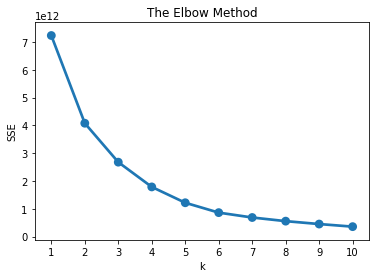

In [8]:
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster cente
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(datamart)
cluster_labels = kmeans.labels_
datamart_rfm_k4 = datamart.assign(Cluster = cluster_labels)
datamart_rfm_k4.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean','count']}).round(1)

Recency Frequency MonetaryValue        
           mean      mean          mean   count
Cluster                                        
0         767.2       1.5        2602.0  169008
1         163.0      20.8       47151.0    1353
2         357.0       5.8       12374.8   19949
3          15.6     152.8      349640.8      10

In [10]:
#第0群的消費者平均已經兩年多沒有購物了>建議之後分析可以略過這群消費者
#第1群的消費者在半年內仍有購物(且之前的購物頻率算高)，可以好好去經營他們，刺激他們二次消費
#第2群的消費者在一年內有購物，但是根據R和F兩個變項來看，感覺即將要流失，公司可以想辦法去挽回他們
#第3群的顧客可以說是VVIP顧客，R,F,M都超級理想，但是也才10個人而已

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]

In [12]:
datamart_rfm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
MemberID,,,,
%2B%2B%2FsALKlNdkh585nb%2F9geIrN84FIZZLkD8qf909HvCU%3D,310,1,2850,0
%2B%2B2Sw%2FYbIovLROVPDc%2BeVjbEdn6fTeg7niPBE%2FeJJKo%3D,706,1,1380,0
%2B%2B3XVjBiQPLoAXWc7gK%2BTdvTH4J4AmgkeFlB3mmN7YY%3D,375,2,5240,0
%2B%2B44iA8rzzl4lYN3dzParPLqAXetHBSwDFIBUBD%2B%2Bt4%3D,240,1,1900,0
%2B%2B6Xs%2FwHblxbDDDYQ9osx6DMUooacHVpAJvv7KWgf3o%3D,1408,1,1280,0


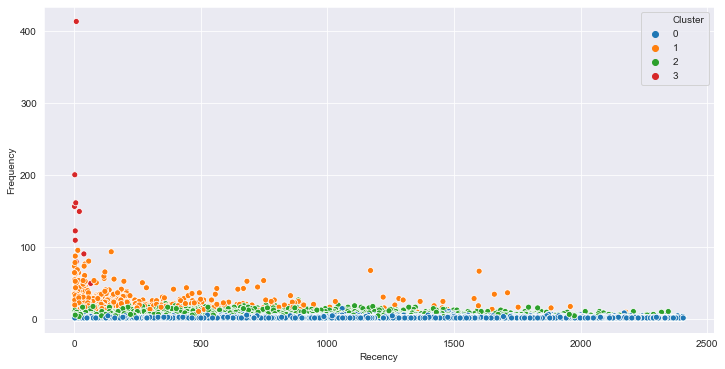

In [13]:
palette ={0:"C0",1:"C1",2:"C2",3:"C3"}
sns.scatterplot(x='Recency', y='Frequency', data=datamart_rfm_k4, hue='Cluster', palette=palette)

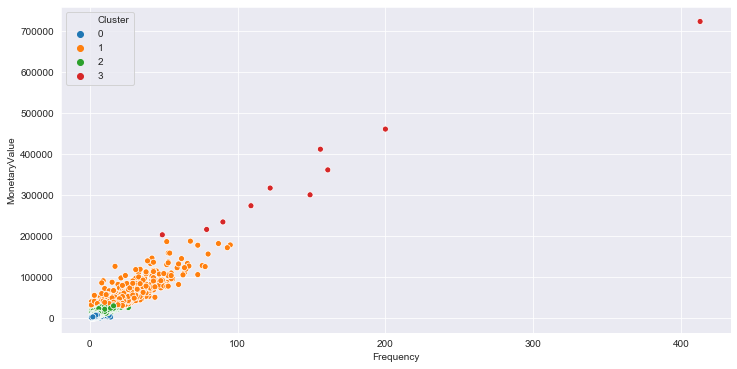

In [14]:
palette ={0:"C0",1:"C1",2:"C2",3:"C3"}
sns.scatterplot(x='Frequency', y='MonetaryValue', data=datamart_rfm_k4, hue='Cluster', palette=palette)

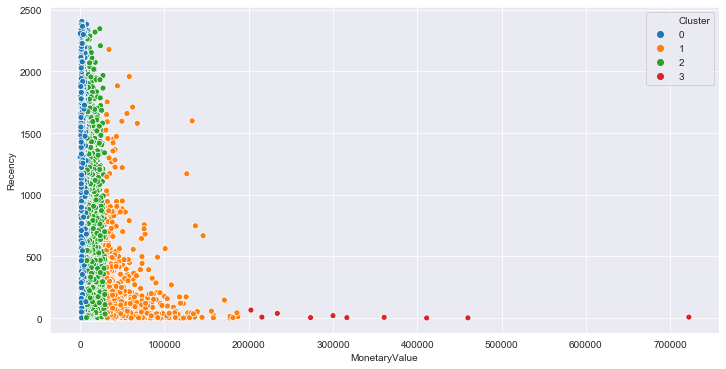

In [15]:
palette ={0:"C0",1:"C1",2:"C2",3:"C3"}
sns.scatterplot(x='MonetaryValue', y='Recency', data=datamart_rfm_k4, hue='Cluster', palette=palette)

# 顧客保留率

In [17]:
def get_month(x): return dt.datetime(x.year,x.month,1)
online['TradesDateTime'] = pd.to_datetime(online['TradesDateTime']).apply(get_month)
newonline=online[online['TradesDateTime']>"2019"]
grouping = newonline.groupby('MemberID')['TradesDateTime'].transform('min') #找出顧客最早有購買紀錄的時間
newonline['CohortMonth'] = grouping
def get_date_int(df, column):
    df[column]=pd.to_datetime(df[column])
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = get_date_int(newonline,'TradesDateTime')
cohort_year, cohort_month, _ = get_date_int(newonline,'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
newonline['CohortIndex'] = years_diff * 12 + months_diff + 1  #觀察多久

C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [18]:
newonline["CohortMonth"]=newonline["CohortMonth"].apply(lambda x:str(x)[:10])
grouping = newonline.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['MemberID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_data.head()

C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CohortMonth,CohortIndex,MemberID
0,2019-02-01,1,5238
1,2019-02-01,2,566
2,2019-02-01,3,504
3,2019-02-01,4,466
4,2019-02-01,5,373


In [19]:
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='MemberID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CohortMonth,,,,,,,,,,,,,,,
2019-02-01,5238.0,566.0,504.0,466.0,373.0,290.0,336.0,314.0,396.0,454.0,371.0,351.0,279.0,288.0,254.0
2019-03-01,5792.0,670.0,447.0,352.0,304.0,296.0,278.0,404.0,434.0,377.0,335.0,259.0,272.0,245.0,NaN
2019-04-01,5853.0,696.0,404.0,307.0,328.0,312.0,444.0,474.0,382.0,361.0,257.0,270.0,283.0,NaN,NaN
2019-05-01,5943.0,595.0,299.0,276.0,230.0,331.0,356.0,327.0,289.0,218.0,220.0,183.0,NaN,NaN,NaN
2019-06-01,5555.0,484.0,279.0,230.0,292.0,354.0,280.0,255.0,158.0,193.0,170.0,NaN,NaN,NaN,NaN
2019-07-01,4698.0,350.0,193.0,244.0,274.0,222.0,214.0,133.0,158.0,121.0,NaN,NaN,NaN,NaN,NaN
2019-08-01,4383.0,364.0,245.0,291.0,252.0,231.0,138.0,171.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,4245.0,429.0,234.0,195.0,176.0,111.0,122.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,5104.0,560.0,338.0,261.0,192.0,184.0,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#近一年的客戶保持率變化
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CohortMonth,,,,,,,,,,,,,,,
2019-02-01,100.0,10.8,9.6,8.9,7.1,5.5,6.4,6.0,7.6,8.7,7.1,6.7,5.3,5.5,4.8
2019-03-01,100.0,11.6,7.7,6.1,5.2,5.1,4.8,7.0,7.5,6.5,5.8,4.5,4.7,4.2,NaN
2019-04-01,100.0,11.9,6.9,5.2,5.6,5.3,7.6,8.1,6.5,6.2,4.4,4.6,4.8,NaN,NaN
2019-05-01,100.0,10.0,5.0,4.6,3.9,5.6,6.0,5.5,4.9,3.7,3.7,3.1,NaN,NaN,NaN
2019-06-01,100.0,8.7,5.0,4.1,5.3,6.4,5.0,4.6,2.8,3.5,3.1,NaN,NaN,NaN,NaN
2019-07-01,100.0,7.4,4.1,5.2,5.8,4.7,4.6,2.8,3.4,2.6,NaN,NaN,NaN,NaN,NaN
2019-08-01,100.0,8.3,5.6,6.6,5.7,5.3,3.1,3.9,2.6,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,100.0,10.1,5.5,4.6,4.1,2.6,2.9,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,100.0,11.0,6.6,5.1,3.8,3.6,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


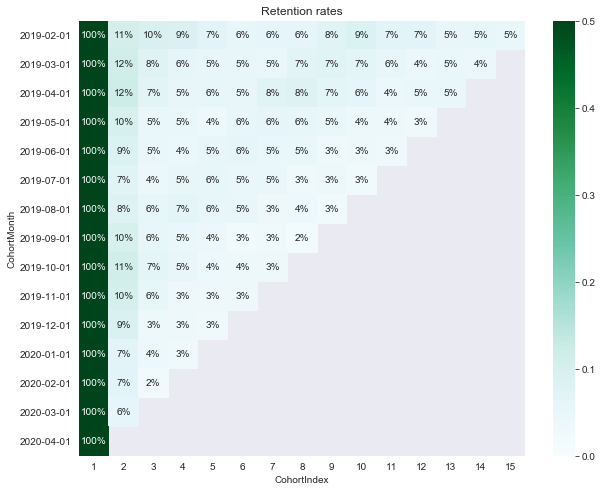

In [21]:
plt.figure(figsize=(10, 8)) 
plt.title('Retention rates')
#小數點後零位，並且以百分比行式輸出
#annot : 如果為True，則將數值填入每個方格中
#vmax,vmin:圖例中最大值和最小值的顯示值
#%matplotlib inline
sns.heatmap(data = retention,annot = True,fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuGn') 
plt.show()

In [22]:
rfm=pd.DataFrame(datamart_rfm_k4["Cluster"])
rfm.head()

,Cluster
MemberID,
%2B%2B%2FsALKlNdkh585nb%2F9geIrN84FIZZLkD8qf909HvCU%3D,0
%2B%2B2Sw%2FYbIovLROVPDc%2BeVjbEdn6fTeg7niPBE%2FeJJKo%3D,0
%2B%2B3XVjBiQPLoAXWc7gK%2BTdvTH4J4AmgkeFlB3mmN7YY%3D,0
%2B%2B44iA8rzzl4lYN3dzParPLqAXetHBSwDFIBUBD%2B%2Bt4%3D,0
%2B%2B6Xs%2FwHblxbDDDYQ9osx6DMUooacHVpAJvv7KWgf3o%3D,0


In [23]:
rfm.to_csv("rfm.csv")